<h1>Analysis of Azog C1 chip: chip characterisation</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [2]:
sample_name = 'azog_c1'                    # name of the chip in the fridge
date_suffixe = '20220131'
user = 'ncr'                               # who is performing measurements

<h3>Basic imports and database loading</h3>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize
import tqdm.notebook as tqdm

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
db_name = 'chip_characterisation_v2.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

qc.initialise_or_create_database_at(db_path)

<h2>Data analysis and plotting</h2>

<h4>IV of the Bloch array as a function of the applied flux</h4>

In [179]:
# loading
RUN_ID = 4 # 4, 38, 45, 46
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [180]:
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()

Ib_up = ivf_up_1['current_source_current'].to_numpy()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()

Ib_down = ivf_down_1['current_source_current'].to_numpy()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
if RUN_ID == 4:
    N = 20000
if RUN_ID == 38:
    N = 25234
if RUN_ID == 45:
    N = 11998    
    
size = (-1, N)

Ib_up = np.reshape(Ib_up, size)
v_up = np.reshape(v_up, size)
i_up = np.reshape(i_up, size)
Ib_down = np.reshape(Ib_down, size)
v_down = np.reshape(v_down, size)
i_down = np.reshape(i_down, size)

# divide into low-to-high and high-to-low
M = len(i_up)
zero_index_up = np.argmin(np.abs(i_up[51]))
zero_index_down = np.argmin(np.abs(i_down[51]))

v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
v_hl = np.zeros((M, zero_index_down + zero_index_up))
i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
i_hl = np.zeros((M, zero_index_down + zero_index_up))

for i in range(M):
    v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), v_up[i][zero_index_up:] ))
    v_hl[i] = np.concatenate(( v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
    i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), i_up[i][zero_index_up:] ))
    i_hl[i] = np.concatenate(( i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

<h5>Plotting</h5>

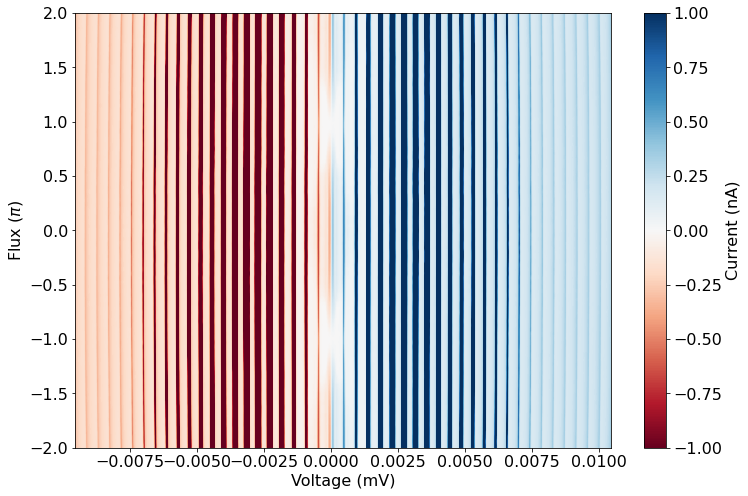

In [181]:
# plotting
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(12,8))
voltage_scaling = 1
voltage_offset = 0.45e-3
current_scaling = 1e9

plt.imshow(current_scaling*i_lh, aspect='auto', 
           extent=[voltage_scaling*(np.min(v_lh[0]) + voltage_offset), voltage_scaling*(np.max(v_lh[0]) + voltage_offset), -2, 2], 
           vmin = -1, vmax=1, cmap='RdBu')
plt.xlabel('Voltage (mV)')
plt.ylabel('Flux ($\pi$)')
plt.colorbar(label='Current (nA)')

# plt.hlines(-1, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
# plt.hlines(0, -5, 5, linestyles='dashed', colors='black', alpha=0.5)

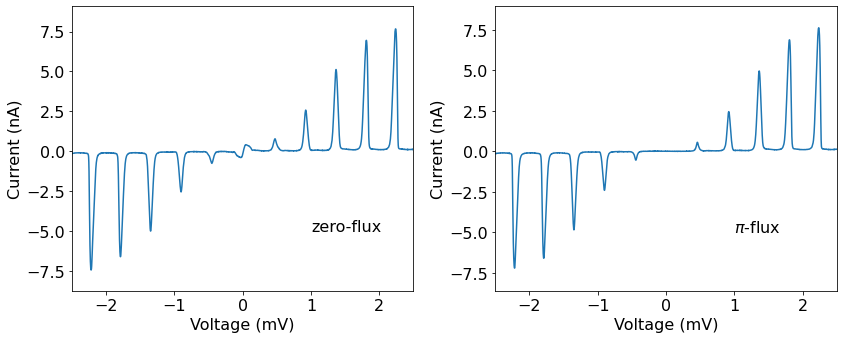

In [182]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
n1 = 50
n2 = 75
voltage_scaling = 1e3
voltage_offset = 0.45e-3
current_scaling = 1e9

# better to go for linspace since the biggest error is the adwin readout of the voltage
xv_lh = voltage_scaling*np.linspace(np.min(v_lh[n1]) + voltage_offset, np.max(v_hl[n1]) + voltage_offset, len(i_hl[n1]))
xv_lh = voltage_scaling*np.linspace(np.min(v_lh[n1]) + voltage_offset, np.max(v_hl[n1]) + voltage_offset, len(i_hl[n1]))

ax[0].plot(xv_lh, current_scaling*i_hl[n1])
ax[0].set_xlim([-2.5, 2.5])
ax[0].set_xlabel('Voltage (mV)')
ax[0].set_ylabel('Current (nA)')
ax[0].text(1,-5,'zero-flux')

ax[1].plot(xv_lh, current_scaling*i_hl[75])
ax[1].set_xlim([-2.5, 2.5])
ax[1].set_xlabel('Voltage (mV)')
ax[1].set_ylabel('Current (nA)')
ax[1].text(1,-5,'$\pi$-flux')

fig.tight_layout()

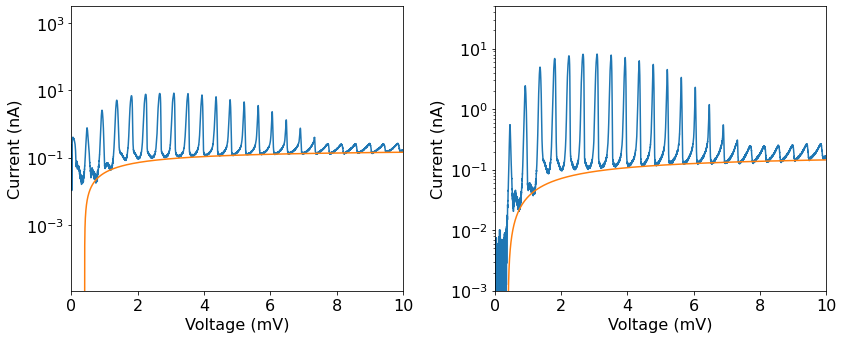

In [183]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
n1 = 50
n2 = 75
voltage_scaling = 1e3
voltage_offset = 0.45e-3
current_scaling = 1e9

# better to go for linspace since the biggest error is the adwin readout of the voltage
xv_lh = voltage_scaling*np.linspace(np.min(v_lh[n1]) + voltage_offset, np.max(v_hl[n1]) + voltage_offset, len(i_hl[n1]))
xv_lh = voltage_scaling*np.linspace(np.min(v_lh[n1]) + voltage_offset, np.max(v_hl[n1]) + voltage_offset, len(i_hl[n1]))

# plots
ax[0].semilogy(xv_lh, np.abs(current_scaling*i_hl[n1]))
ax[0].set_xlim([0, 10])
ax[0].set_xlabel('Voltage (mV)')
ax[0].set_ylabel('Current (nA)')

ax[1].semilogy(xv_lh, np.abs(current_scaling*i_hl[75]))
ax[1].set_xlim([0, 10])
ax[1].set_ylim([1e-3, 50])
ax[1].set_xlabel('Voltage (mV)')
ax[1].set_ylabel('Current (nA)')

# function of the minima (everything is in mV)
v_g = 0.4        # voltage of the gap
scale = 2.2e3    # various gains
r0 = 30e3        # small junction or ohmic resistance
rj = 12e3        # added resistance per unit of mV
def f(v):
    return scale*(v-v_g) / (r0 + rj*(v-v_g))

ax[0].plot(xv_lh, f(xv_lh))
ax[1].plot(xv_lh, f(xv_lh))

fig.tight_layout()
# plt.savefig('resistance_fit.png')

(0.001, 10)

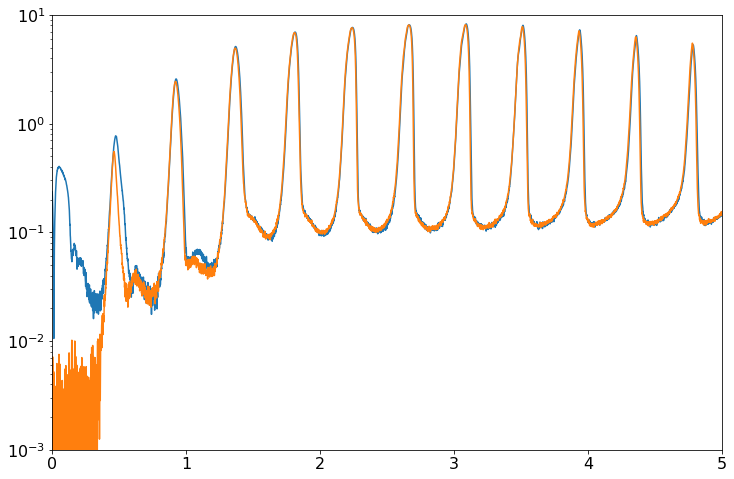

In [184]:
plt.figure(figsize=(12,8))

plt.semilogy(xv_lh, np.abs(current_scaling*i_hl[n1]))
plt.semilogy(xv_lh, np.abs(current_scaling*i_hl[75]))
# plt.semilogy(xv_lh, current_scaling*np.abs(i_hl[n1] - i_hl[75]))
plt.xlim([0, 5])
plt.ylim([1e-3,10])

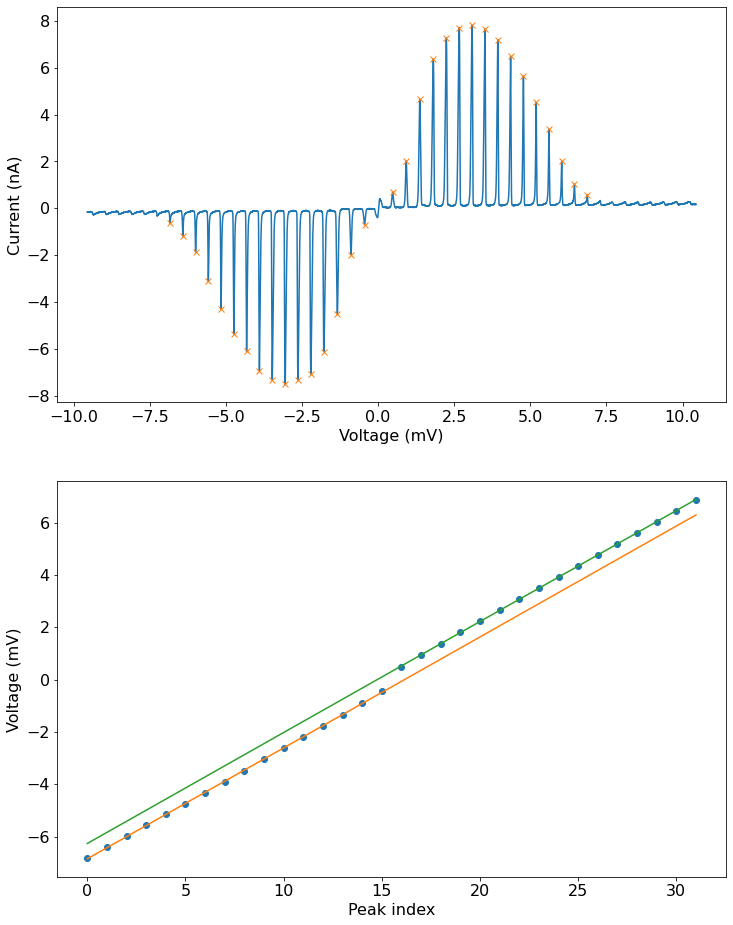

In [185]:
from scipy.signal import find_peaks
current_scaling = 1e9

# search for peaks and plot
distance = 300
height = 0.5
voltage_shift = []

for i in range(M):
    i0 = current_scaling*i_hl[i]

    peaks, _ = find_peaks(abs(i0), distance=distance, height=height)
    np.diff(peaks)
    
    # voltage of the peaks, fit and plot
    n_peaks = len(peaks)
    half_peaks = int( len(peaks)/2 )
    x_fit = np.linspace(0,n_peaks-1,n_peaks)
    fitparameters_negaive = np.polyfit(x_fit[0:half_peaks], xv_lh[peaks][0:half_peaks], 1)
    p_negative = np.poly1d(fitparameters_negaive)
    fitparameters_positive = np.polyfit(x_fit[half_peaks::], xv_lh[peaks][half_peaks::], 1)
    p_positive = np.poly1d(fitparameters_positive)

    if i==0:
        fig, ax = plt.subplots(2, 1, figsize=(12,16))
        ax[0].plot(xv_lh, i0)
        ax[0].plot(xv_lh[peaks], i0[peaks], 'x')
        ax[0].set_xlabel('Voltage (mV)')
        ax[0].set_ylabel('Current (nA)')

        ax[1].plot(x_fit, xv_lh[peaks], 'o')
        ax[1].plot(x_fit, p_negative(x_fit))
        ax[1].plot(x_fit, p_positive(x_fit))
        ax[1].set_xlabel('Peak index')
        ax[1].set_ylabel('Voltage (mV)')

    voltage_shift.append( (p_positive[0]-p_negative[0])/2 )
    # print('The estimated voltage shift is',(p_positive[0]-p_negative[0])/2, 'mV')

(0.285, 0.295)

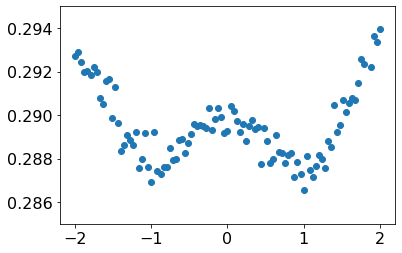

In [186]:
x_flux = np.linspace(-2, 2, 101)
plt.plot(x_flux, voltage_shift, 'o')
plt.ylim([0.285,0.295])

<h4>VNA trace as function of the DC bias, with superimposed IV curve</h4>

In [10]:
# loading vna data
RUN_ID = 17
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 20
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [11]:
# IV curve
vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# divide into low-to-high and high-to-low
N = len(v_up)
zero_index_up = np.argmin(np.abs(i_up))
zero_index_down = np.argmin(np.abs(i_down))

v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

<h5>Plotting</h5>

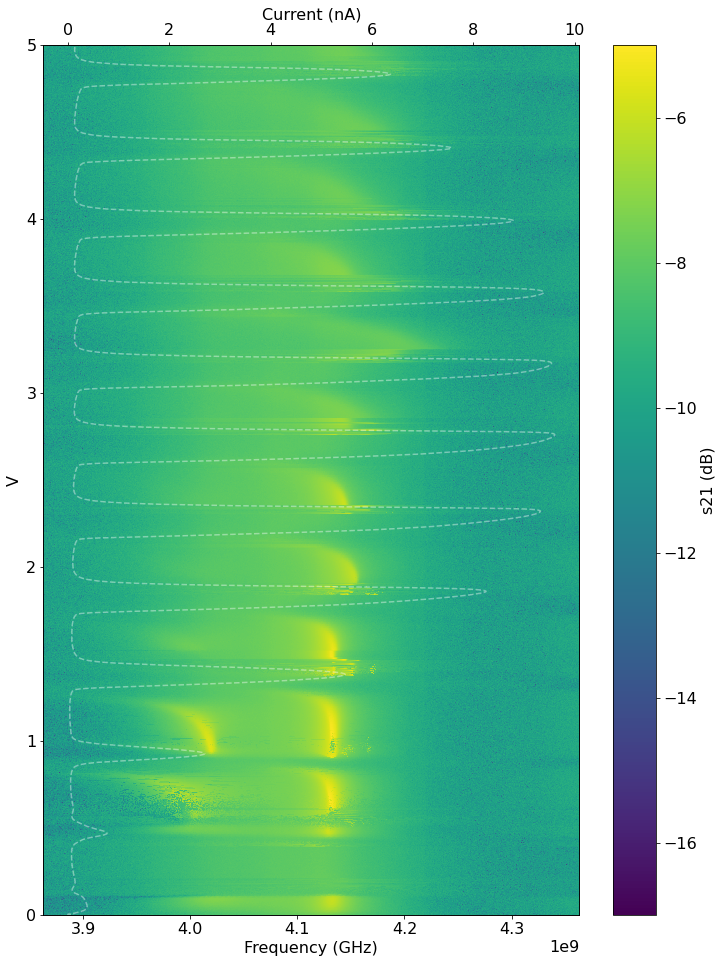

In [12]:
fig, ax1 = plt.subplots(figsize=(12,16))
voltage_scaling = 1e3
voltage_offset = 0.05
current_scaling = 1e9

ctf = ax1.pcolormesh(frq, v_bias, np.log(mag), shading='nearest')
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('V')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylim([0,5])
# ax1.set_ylim([-10,0])

ax2 =ax1.twiny()
ax2.plot(current_scaling*np.abs(i_up), voltage_scaling*v_up - voltage_offset, 'w--', alpha=0.4)
ax2.set_xlabel('Current (nA)');

# plt.savefig('s21_dc.png')

<h5>Same but with $\pi$ flux</h5>

In [198]:
# loading vna data
RUN_ID = 47
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_flux0_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 51
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_fluxpi_dict = dataset.to_pandas_dataframe_dict()

In [199]:
# VNA spectra 0 flux
vnadc_vna_0 = vnadc_flux0_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq_0 = np.reshape(frq, m_size)
v_bias_0 = np.reshape(v_bias, m_size)
mag_0 = np.reshape(mag, m_size)

# VNA spectra pi flux
vnadc_vna_0 = vnadc_fluxpi_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq_pi = np.reshape(frq, m_size)
v_bias_pi = np.reshape(v_bias, m_size)
mag_pi = np.reshape(mag, m_size)

Text(0, 0.5, 'Voltage (mV)')

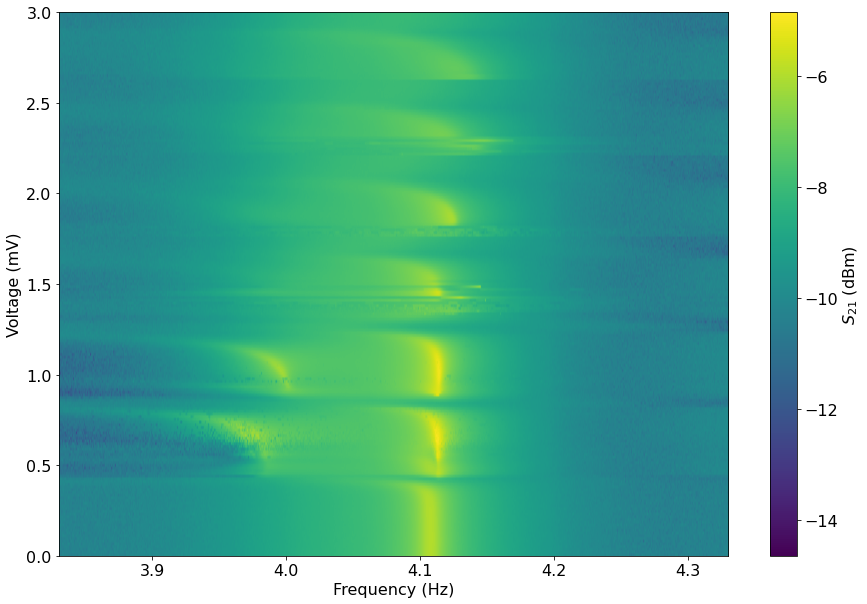

In [214]:
plt.figure(figsize=(15,10))
frequency_scale = 1e-9

plt.imshow( np.log(mag_pi[::-1]), aspect='auto',
            extent=[ frequency_scale*np.min(frq_pi), frequency_scale*np.max(frq_pi), np.min(v_bias_pi), np.max(v_bias_pi) ] )
plt.colorbar(label='$S_{21}$ (dBm)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Voltage (mV)')
# ax[1].imshow(np.log(mag_0), aspect='auto')

<h4>Blockade at low voltage (when pumping) as a function of the applied flux</h4>

In [5]:
# loading
RUN_ID = 44 # 4, 38, 45, 46
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [6]:
# IV
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

i_flux_up = ivf_up_1['current_source_current'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

i_flux_down = ivf_down_1['current_source_current'].to_numpy()


In [7]:
N = np.unique(i_flux_up).shape[0]
size = (N,-1)

v_up = np.reshape(v_up,size)
i_up = np.reshape(i_up, size)
i_flux_up = np.reshape(i_flux_up, size)


In [8]:
N

101

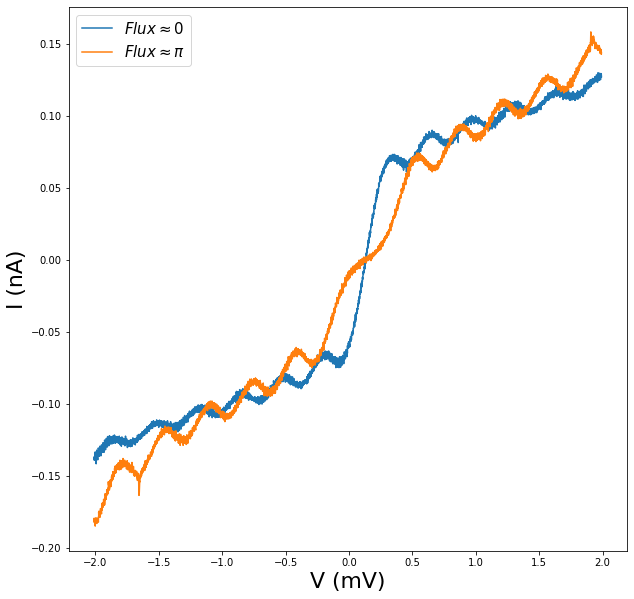

In [20]:
plt.figure(figsize=(10,10))
k=50
plt.plot(v_up[k, :]*30*1e3,1e9*i_up[k, :], label = r"$Flux\approx 0$")

k=62
plt.plot(v_up[k, :]*30 *1e3,1e9*i_up[k, :], label = r"$Flux\approx \pi$")

plt.xlabel("V (mV)", fontsize=22)
plt.ylabel("I (nA)", fontsize=22)
plt.legend(fontsize=15)
plt.savefig("pumped_IVs.png")

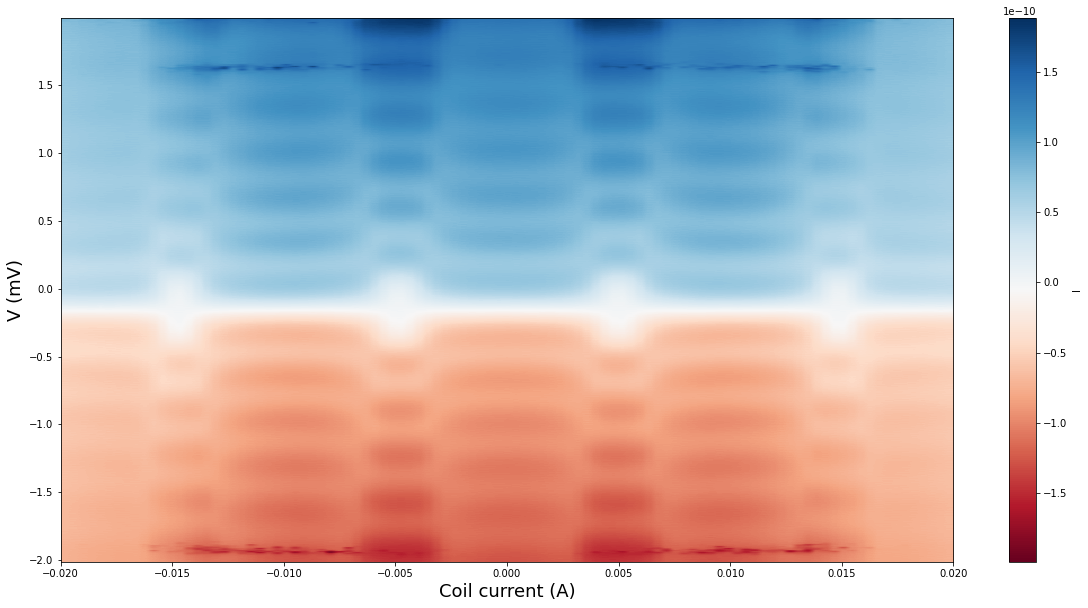

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(-i_up[:, :]),  aspect='auto', cmap='RdBu',
            extent = [np.min(i_flux_up), np.max(i_flux_up), np.min(v_up)*30* 1e3, np.max(v_up)*30*1e3 ] )
plt.xlabel("Coil current (A)", fontsize=18)
plt.ylabel("V (mV)", fontsize=18)
plt.colorbar(label=r'I')
plt.savefig("2D_pumped_IVs.png")

In [26]:

import sys

import logging
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg as splin

_has_matplotlib = True
try:
    import matplotlib.pyplot as plt
except ImportError:
    _has_matplotlib = False
    logging.warning("Matplotlib is not installed - plotting "
                    "functionality disabled")


def log_iteration(ii, s0, u, g):
    relative_change = np.linalg.norm(s0) / np.linalg.norm(u)
    g_norm = np.linalg.norm(g)
    logging.info('iteration {0:4d}: relative change = {1:.3e}, '
                 'gradient norm = {2:.3e}\n'.format(ii,
                                                    relative_change,
                                                    g_norm))


def TVRegDiff(data, itern, alph, u0=None, scale='small', ep=1e-6, dx=None,
              plotflag=_has_matplotlib, diagflag=True, precondflag=True,
              diffkernel='abs', cgtol=1e-4, cgmaxit=100):
    """
    Estimate derivatives from noisy data based using the Total 
    Variation Regularized Numerical Differentiation (TVDiff) 
    algorithm.

    Parameters
    ----------
    data : ndarray
        One-dimensional array containing series data to be
        differentiated.
    itern : int
        Number of iterations to run the main loop.  A stopping
        condition based on the norm of the gradient vector g
        below would be an easy modification.  No default value.
    alph : float    
        Regularization parameter.  This is the main parameter
        to fiddle with.  Start by varying by orders of
        magnitude until reasonable results are obtained.  A
        value to the nearest power of 10 is usally adequate.
        No default value.  Higher values increase
        regularization strenght and improve conditioning.
    u0 : ndarray, optional
        Initialization of the iteration.  Default value is the
        naive derivative (without scaling), of appropriate
        length (this being different for the two methods).
        Although the solution is theoretically independent of
        the initialization, a poor choice can exacerbate
        conditioning issues when the linear system is solved.
    scale : {large' or 'small' (case insensitive)}, str, optional   
        Default is 'small'.  'small' has somewhat better boundary
        behavior, but becomes unwieldly for data larger than
        1000 entries or so.  'large' has simpler numerics but
        is more efficient for large-scale problems.  'large' is
        more readily modified for higher-order derivatives,
        since the implicit differentiation matrix is square.
    ep : float, optional 
        Parameter for avoiding division by zero.  Default value
        is 1e-6.  Results should not be very sensitive to the
        value.  Larger values improve conditioning and
        therefore speed, while smaller values give more
        accurate results with sharper jumps.
    dx : float, optional    
        Grid spacing, used in the definition of the derivative
        operators.  Default is the reciprocal of the data size.
    plotflag : bool, optional
        Flag whether to display plot at each iteration.
        Default is True.  Useful, but adds significant
        running time.
    diagflag : bool, optional
        Flag whether to display diagnostics at each
        iteration.  Default is True.  Useful for diagnosing
        preconditioning problems.  When tolerance is not met,
        an early iterate being best is more worrying than a
        large relative residual.
    precondflag: bool, optional
        Flag whether to use a preconditioner for conjugate gradient solution.
        Default is True. While in principle it should speed things up, 
        sometimes the preconditioner can cause convergence problems instead,
        and should be turned off. Note that this mostly makes sense for 'small'
        scale problems; for 'large' ones, the improved preconditioner is one
        of the main features of the algorithms and turning it off defeats the
        point.
    diffkernel: str, optional
        Kernel to use in the integral to smooth the derivative. By default it's
        the absolute value, |u'| (value: "abs"). However, it can be changed to
        being the square, (u')^2 (value: "sq"). The latter produces smoother
        derivatives, whereas the absolute values tends to make them more blocky.
        Default is abs.
    cgtol: float, optional
        Tolerance to use in conjugate gradient optimisation. Default is 1e-4.
    cgmaxit: int, optional
        Maximum number of iterations to use in conjugate gradient optimisation. 
        Default is 100


    Returns
    -------
    u : ndarray
        Estimate of the regularized derivative of data.  Due to
        different grid assumptions, length(u) = length(data) + 1
        if scale = 'small', otherwise length(u) = length(data).
    """

    # Make sure we have a column vector
    data = np.array(data)
    assert len(data.shape) == 1, "data is not one-dimensional"
    # Get the data size.
    n = len(data)

    # Default checking. (u0 is done separately within each method.)
    if dx is None:
        dx = 1.0 / n

    # Different methods for small- and large-scale problems.
    if (scale.lower() == 'small'):

        # Differentiation operator
        d0 = -np.ones(n)/dx
        du = np.ones(n-1)/dx
        dl = np.zeros(n-1)
        dl[-1] = d0[-1]
        d0[-1] *= -1

        D = sparse.diags([dl, d0, du], [-1, 0, 1])
        DT = D.transpose()

        # Antidifferentiation and its adjoint
        def A(x): return (np.cumsum(x) - 0.5 * (x + x[0])) * dx

        def AT(x): return np.concatenate([[sum(x[1:])/2.0],
                                          (sum(x)-np.cumsum(x)+0.5*x)[1:]])*dx

        # Default initialization is naive derivative

        if u0 is None:
            u0 = D*data

        u = u0.copy()
        # Since Au( 0 ) = 0, we need to adjust.
        ofst = data[0]
        # Precompute.
        ATb = AT(ofst - data)        # input: size n

        # Main loop.
        for ii in range(1, itern+1):
            if diffkernel == 'abs':
                # Diagonal matrix of weights, for linearizing E-L equation.
                Q = sparse.spdiags(1. / (np.sqrt((D * u)**2 + ep)), 0, n, n)
                # Linearized diffusion matrix, also approximation of Hessian.
                L = dx * DT * Q * D
            elif diffkernel == 'sq':
                L = dx * DT * D
            else:
                raise ValueError('Invalid diffkernel value')

            # Gradient of functional.
            g = AT(A(u)) + ATb + alph * L * u

            # Prepare to solve linear equation.
            if precondflag:
                # Simple preconditioner.
                P = alph * sparse.spdiags(L.diagonal() + 1, 0, n, n)
            else:
                P = None

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n, n), linop)

            s, info_i = sparse.linalg.cg(
                linop, g, x0=None, tol=cgtol, maxiter=cgmaxit,
                callback=None, M=P, atol='legacy')

            if diagflag:
                log_iteration(ii, s[0], u, g)
                if (info_i > 0):
                    logging.warning(
                        "WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    logging.warning("WARNING - illegal input or breakdown")

            # Update solution.
            u = u - s
            # Display plot.
            if plotflag:
                plt.plot(u)
                plt.show()

    elif (scale.lower() == 'large'):

        # Construct anti-differentiation operator and its adjoint.
        def A(v): return np.cumsum(v)

        def AT(w): return (sum(w) * np.ones(len(w)) -
                           np.transpose(np.concatenate(([0.0],
                                                        np.cumsum(w[:-1])))))
        # Construct differentiation matrix.
        c = np.ones(n)
        D = sparse.spdiags([-c, c], [0, 1], n, n) / dx
        mask = np.ones((n, n))
        mask[-1, -1] = 0.0
        D = sparse.dia_matrix(D.multiply(mask))
        DT = D.transpose()
        # Since Au( 0 ) = 0, we need to adjust.
        data = data - data[0]
        # Default initialization is naive derivative.
        if u0 is None:
            u0 = np.concatenate(([0], np.diff(data)))
        u = u0
        # Precompute.
        ATd = AT(data)

        # Main loop.
        for ii in range(1, itern + 1):

            if diffkernel == 'abs':
                # Diagonal matrix of weights, for linearizing E-L equation.
                Q = sparse.spdiags(1. / (np.sqrt((D * u)**2 + ep)), 0, n, n)
                # Linearized diffusion matrix, also approximation of Hessian.
                L = DT * Q * D
            elif diffkernel == 'sq':
                L = DT * D
            else:
                raise ValueError('Invalid diffkernel value')

            # Gradient of functional.
            g = AT(A(u)) - ATd
            g = g + alph * L * u
            # Build preconditioner.
            if precondflag:
                c = np.cumsum(range(n, 0, -1))
                B = alph * L + sparse.spdiags(c[::-1], 0, n, n)
                # droptol = 1.0e-2
                R = sparse.dia_matrix(np.linalg.cholesky(B.todense()))
                P = np.dot(R.transpose(), R)
            else:
                P = None
            # Prepare to solve linear equation.

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n, n), linop)

            s, info_i = sparse.linalg.cg(
                linop, -g, x0=None, tol=cgtol, maxiter=cgmaxit, callback=None,
                M=P, atol='legacy')
            if diagflag:
                log_iteration(ii, s[0], u, g)
                if (info_i > 0):
                    logging.warning(
                        "WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    logging.warning("WARNING - illegal input or breakdown")

            # Update current solution
            u = u + s
            # Display plot
            if plotflag:
                plt.plot(u / dx)
                plt.show()

        u = u / dx

    return u


In [139]:
dIdv_up = []
for k in tqdm.tqdm(range(i_up.shape[0])):
    data = i_up[k, :] - i_up[k, 0]
    dIdv = TVRegDiff(data, itern=20, alph=0.1, plotflag=False, cgtol=1e-4)
    dIdv_up.append(dIdv/(v_up[0,-1] - v_up[0,0]))
dIdv_up = np.array(dIdv_up)

  0%|          | 0/101 [00:00<?, ?it/s]

Text(0, 0.5, 'dIdV')

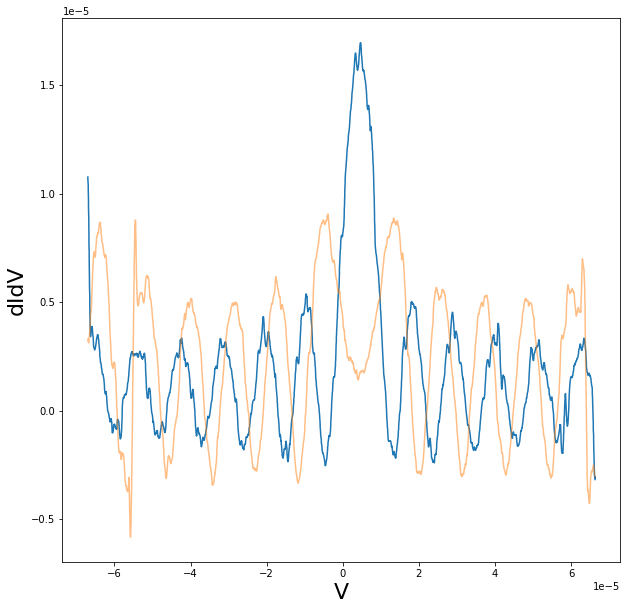

In [143]:
plt.figure(figsize=(10,10))
k=50
plt.plot(v_up[k, :],dIdv_up[k, :])

k=62
plt.plot(v_up[k, :],dIdv_up[k, :], alpha=0.5)

plt.xlabel("V", fontsize=22)
plt.ylabel("dIdV", fontsize=22)

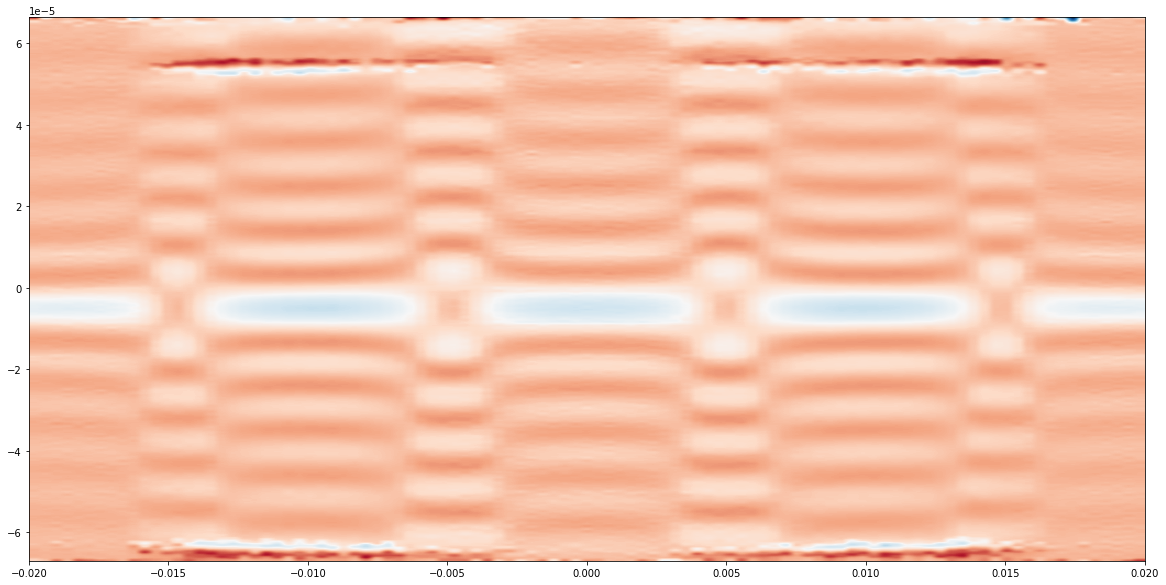

In [142]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(dIdv_up[:, :]),  aspect='auto', cmap='RdBu',
          extent = [np.min(i_flux_up), np.max(i_flux_up), np.min(v_up), np.max(v_up) ])